## Summary

In this notebook we load a network trained to solve Sudoku puzzles and run this network to solve a single Sudoku.

----

## Imports

In [1]:
import os
import sys
import tempfile
import time
from collections import deque
from pathlib import Path

import tqdm
from torch_geometric.data import DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow
import torch
import torch.nn as nn
from matplotlib import cm

In [2]:
import proteinsolver
import proteinsolver.datasets
from proteinsolver.utils import gen_sudoku_graph_featured

/home/ubuntu/anaconda3/envs/defaults-v009/lib/python3.7/site-packages/Bio/KDTree/__init__.py:25: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning)


In [3]:
%matplotlib inline

try:
    inline_rc
except NameError:
    inline_rc = mpl.rcParams.copy()
    
mpl.rcParams.update({"font.size": 12})

## Parameters

In [4]:
UNIQUE_ID = "c8de7e56"

In [5]:
DATA_ROOT = Path(tempfile.gettempdir())
DATA_ROOT.mkdir(exist_ok=True)
DATA_ROOT

PosixPath('/tmp')

In [6]:
NOTEBOOK_NAME = "sudoku_demo"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME)
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('sudoku_demo')

In [7]:
DATAPKG_DATA_DIR = Path(f"~/datapkg_data_dir").expanduser().resolve()
DATAPKG_DATA_DIR

PosixPath('/data/datapkg_data_dir')

In [8]:
proteinsolver.settings.data_url = DATAPKG_DATA_DIR.as_posix()
proteinsolver.settings.data_url

'/data/datapkg_data_dir'

## Load model

In [9]:
%run sudoku_train/{UNIQUE_ID}/model.py

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [11]:
state_files = sorted(
    Path("sudoku_train").joinpath(UNIQUE_ID).glob("*.state"),
    key=lambda s: (int(s.stem.split("-")[3].strip("amv")), int(s.stem.split("-")[2].strip("d"))),
)

state_files[-5:]

[PosixPath('sudoku_train/c8de7e56/e1-s400000-d2400000-amv07269.state'),
 PosixPath('sudoku_train/c8de7e56/e1-s600000-d3600000-amv07396.state')]

In [12]:
state_file = state_files[-2]
state_file

PosixPath('sudoku_train/c8de7e56/e1-s400000-d2400000-amv07269.state')

In [13]:
net = Net(
    x_input_size=13, adj_input_size=3, hidden_size=162, output_size=9, batch_size=8
).to(device)

net.load_state_dict(torch.load(state_file, map_location=device))
net = net.eval()
net = net.eval().to(device)

## Define helper functions

In [14]:
def encode_puzzle(puzzle):
    puzzle = puzzle - 1
    puzzle = torch.where(puzzle >= 0, puzzle, torch.tensor(9))
    return puzzle

In [15]:
def decode_puzzle(puzzle):
    puzzle = (puzzle + 1) % 10
    return puzzle

In [16]:
puzzle = torch.tensor([1,1,1])
assert torch.equal(decode_puzzle(encode_puzzle(puzzle)), puzzle)

In [17]:
def solve_sudoku(net, puzzle):
    sudoku_graph = torch.from_numpy(gen_sudoku_graph_featured()).to_sparse(2)
    edge_index = sudoku_graph.indices()
    edge_attr = sudoku_graph.values()

    output = net(encode_puzzle(puzzle).view(-1), edge_index, edge_attr)
    output = torch.softmax(output, dim=1)
    _, predicted = output.max(dim=1)

    return decode_puzzle(predicted).reshape(9, 9)

In [18]:
def show_sudoku(puzzle, solved=None, pred=None, ax=None):
    # Simple plotting statement that ingests a 9x9 array (n), and plots a sudoku-style grid around it.
    if ax is None:
        _, ax = plt.subplots()

    for y in range(10):
        ax.plot([-0.05, 9.05], [y, y], color="black", linewidth=1)

    for y in range(0, 10, 3):
        ax.plot([-0.05, 9.05], [y, y], color="black", linewidth=3)

    for x in range(10):
        ax.plot([x, x], [-0.05, 9.05], color="black", linewidth=1)

    for x in range(0, 10, 3):
        ax.plot([x, x], [-0.05, 9.05], color="black", linewidth=3)

    ax.axis("image")
    ax.axis("off")  # drop the axes, they're not important here

    for x in range(9):
        for y in range(9):
            puzzle_element = puzzle[8 - y][
                x
            ]  # need to reverse the y-direction for plotting
            if puzzle_element > 0:  # ignore the zeros
                T = f"{puzzle_element}"
                ax.text(x + 0.3, y + 0.2, T, fontsize=20)
            elif solved is not None and pred is not None:
                solved_element = solved[8 - y][x]
                pred_element = pred[8 - y][x]
                if solved_element == pred_element:
                    T = f"{solved_element}"
                    ax.text(x + 0.3, y + 0.2, T, fontsize=20, color="b")
                else:
                    ax.text(x + 0.1, y + 0.3, f"{pred_element}", fontsize=13, color="r")
                    ax.text(
                        x + 0.55, y + 0.3, f"{solved_element}", fontsize=13, color="g"
                    )

## Solve a simple puzzle

### Input sudoku puzzle

In [19]:
puzzle = torch.tensor(
    [
        [0, 8, 0, 0, 3, 2, 0, 0, 1],
        [7, 0, 3, 0, 8, 0, 0, 0, 2],
        [5, 0, 0, 0, 0, 7, 0, 3, 0],
        [0, 5, 0, 0, 0, 1, 9, 7, 0],
        [6, 0, 0, 7, 0, 9, 0, 0, 8],
        [0, 4, 7, 2, 0, 0, 0, 5, 0],
        [0, 2, 0, 6, 0, 0, 0, 0, 9],
        [8, 0, 0, 0, 9, 0, 3, 0, 5],
        [3, 0, 0, 8, 2, 0, 0, 1, 0],
    ]
)

### Input solution (for reference)

In [20]:
solution = torch.tensor(
    [
        [4, 8, 9, 5, 3, 2, 7, 6, 1],
        [7, 1, 3, 4, 8, 6, 5, 9, 2],
        [5, 6, 2, 9, 1, 7, 8, 3, 4],
        [2, 5, 8, 3, 4, 1, 9, 7, 6],
        [6, 3, 1, 7, 5, 9, 2, 4, 8],
        [9, 4, 7, 2, 6, 8, 1, 5, 3],
        [1, 2, 5, 6, 7, 3, 4, 8, 9],
        [8, 7, 6, 1, 9, 4, 3, 2, 5],
        [3, 9, 4, 8, 2, 5, 6, 1, 7],
    ]
)

In [21]:
assert proteinsolver.utils.sudoku.sudoku_is_solved(solution)

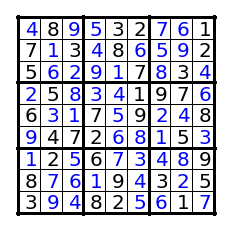

In [22]:
show_sudoku(puzzle, solution, solution)

### Use trained network to solve puzzle

In [23]:
solution_pred = solve_sudoku(net, puzzle)

In [24]:
proteinsolver.utils.sudoku.sudoku_is_solved(solution_pred)

True

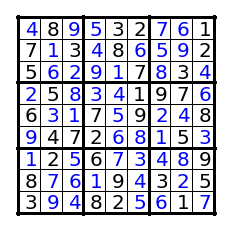

In [25]:
show_sudoku(puzzle, solution, solution_pred)